In [31]:
import pandas as pd
from pathlib import Path
import html
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn import svm
import numpy as np

### Data pre-processing

In [32]:
'''Dataset Construction'''
# Parent directories, 'orginal' stores the original chapters translated by machine or by different translators; 
#                     'cleaned' stores the cleaned files by data pre-processing
ORIGINAL_DIR = Path('original')
CLEANED_DIR = Path('cleaned')

# Chuildren directories for each parent dir
PO_GOO_DIR = Path('po-en-goo') # stores chapters translated by Google Translate from the original version (Polish) of the book Solaris to English
PO_DL_DIR = Path('po-en-dl') # stores chapters translated by DeepL API from the original version (Polish) of the book Solaris to English
FR_GOO_DIR = Path('fr-en-goo') # stores chapters translated by Google Translate from the translated french version of the book Solaris to English
FR_DL_DIR = Path('fr-en-dl') # stores chapters translated by DeepL API from the translated french version of the book Solaris to English
EN1_DIR = Path('en1') # stores chapters of first translated version to English of the book Solaris
EN2_DIR = Path('en2') # stores chapters of second translated version to English of the book Solaris

# List to access children directories
DIRS = [PO_GOO_DIR, PO_DL_DIR, FR_GOO_DIR, FR_DL_DIR, EN1_DIR, EN2_DIR]

# List for all the translations
BOOKS = ['po-en-goo', 'po-en-dl', 'fr-en-goo', 'fr-en-dl', 'en1', 'en2']

In [33]:
# Find out the replacement by checking the vocabularies in parellel chapters for confirmation
TO_REPLACE = {
    'ö': 'o',
    'é': 'e',
    'ë': 'e',
    'ï': 'i',
    'ą': 'a',
    'í': 'i',
    'æ': 'ae',
    'ð': 'ny', # Original - fr-dl[8] 'caðon', changed to based on po-en-goo 'Canyon'
    'à': 'a',
    'å': 'a',
    'â': 'a',
    "'": '', # Replace apostrophe with nothing to protect contractions like don't -> dont
    '’': '',
    ' `': '',
}

In [34]:
# Function to check special characters by checking each translated texts.
allowed="abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789 \n"
def get_not_allowed(txt):
    others = set()
    for i in txt:
        if i not in allowed:
            others.add(i)
    return others

others = set()
for p in DIRS:
    for i in (ORIGINAL_DIR / p).iterdir(): # Checked by each directory contained target data
        with open(i) as f:
            txt = f.read()
            # Change the html punctuation format to the normal one
            txt = html.unescape(txt)
        others = others.union(get_not_allowed(txt))
print(others)

{')', '\x0c', '(', '‘', 'ą', ':', 'é', '`', "'", 'à', 'å', '!', '^', 'ï', '…', '•', '?', '³', 'â', ',', '’', '_', '»', 'ö', '”', ';', '–', 'æ', '“', 'í', '*', '—', 'ð', 'ë', '"', '-', '.'}


In [35]:
'''Data Cleaning'''

for i in DIRS:
    for j in (ORIGINAL_DIR / i).iterdir():
        with open(j) as f:
            txt = f.read()
        
        # Change the html punctuation format to the normal one
        txt = html.unescape(txt)

        # Replace special characters
        for key in TO_REPLACE.keys():
            txt = txt.replace(key, TO_REPLACE[key])

        # Remove special characters
        for each in others:
            txt = txt.replace(each, ' ')
        
        # Lowercase everything
        txt = txt.lower()
        
        if not (CLEANED_DIR / i).is_dir():
            (CLEANED_DIR / i).mkdir(parents=True)

        with open(CLEANED_DIR / i / j.name, 'w') as f:
            f.write(txt)
            

### TF-IDF for the whole corpus

In [36]:
# a set of all the vocabularies in all documents
all_words = set()

for i in DIRS:
    for j in (CLEANED_DIR / i).iterdir():
        with open(j, "r") as f:
            wl = f.read().split()
            all_words = all_words.union(set(wl))
        
all_word_len = len(all_words) 


In [37]:
# Build empty dataframe to store the TF-IDFs from each document
df = pd.DataFrame(0, columns=list(all_words), index=[f"{b}-{i}" for b in BOOKS for i in range(1,15)])

for i in DIRS:
    for j in (CLEANED_DIR / i).iterdir():
        # Extract the number from the file's name (e.g. "po11.txt" -> "11")
        num = re.findall(r'\d+', j.stem)[-1]
        row = f"{i.stem}-{num}"
        with open(j, "r") as f:
            wl = f.read().split()
            for w in wl:
                df.loc[row, w] += 1



#### df2 = the tf-idf for each chapter

In [38]:
# Normalisation
df2 = df.div(df.sum(axis=1), axis=0)
df2.sum(axis=1)

df2

,voice,proportion,cliches,eats,candid,propitiate,chokes,blankly,casings,inoculation,...,toothy,triad,comprehensible,circulations,those,clothespins,protocol,pilot,organised,areopagus
po-en-goo-1,0.001881,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000313,0.0,0.000000,0.000000,0.0,0.0
po-en-goo-2,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000719,0.0,0.000000,0.000000,0.0,0.0
po-en-goo-3,0.000403,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000403,0.0,0.000403,0.000000,0.0,0.0
po-en-goo-4,0.000798,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000399,0.0,0.0
po-en-goo-5,0.001228,0.000000,0.000000,0.0,0.0,0.000205,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000409,0.0,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
en2-10,0.001096,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000548,0.0,0.000000,0.000000,0.0,0.0
en2-11,0.000595,0.000149,0.000149,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.001637,0.0,0.000000,0.000000,0.0,0.0
en2-12,0.000495,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000248,0.0,0.000000,0.000000,0.0,0.0
en2-13,0.001064,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000355,0.0,0.000000,0.000000,0.0,0.0


#### df4 is the tf-idf for each book

In [39]:
df3 = df2.T
df3['po-en-goo'] = df3.loc[:,df3.columns.str.startswith('po-en-goo-')].sum(axis=1)
df3['po-en-dl'] = df3.loc[:,df3.columns.str.startswith('po-en-dl-')].sum(axis=1)
df3['fr-en-goo'] = df3.loc[:,df3.columns.str.startswith('fr-en-goo-')].sum(axis=1)
df3['fr-en-dl'] = df3.loc[:,df3.columns.str.startswith('fr-en-dl-')].sum(axis=1)
df3['en1'] = df3.loc[:,df3.columns.str.startswith('en1-')].sum(axis=1)
df3['en2'] = df3.loc[:,df3.columns.str.startswith('en2-')].sum(axis=1)
df3 = df3/14

# df4 is the tf-idf for each book
df4 = df3.iloc[:,-6:]
df4 = df4.T
df4

,voice,proportion,cliches,eats,candid,propitiate,chokes,blankly,casings,inoculation,...,toothy,triad,comprehensible,circulations,those,clothespins,protocol,pilot,organised,areopagus
po-en-goo,0.000912,0.000000,0.000000,0.000015,0.000000,0.000015,0.000008,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000008,0.000000,0.000542,0.000000,0.000048,0.000038,0.000000,0.000020
po-en-dl,0.000978,0.000019,0.000000,0.000000,0.000000,0.000014,0.000008,0.000019,0.000000,0.000000,...,0.000018,0.000011,0.000000,0.000008,0.000405,0.000019,0.000072,0.000036,0.000012,0.000019
fr-en-goo,0.001268,0.000000,0.000000,0.000000,0.000012,0.000000,0.000000,0.000029,0.000029,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000326,0.000000,0.000000,0.000043,0.000000,0.000020
fr-en-dl,0.001241,0.000000,0.000000,0.000014,0.000012,0.000000,0.000000,0.000029,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000436,0.000000,0.000000,0.000052,0.000034,0.000020
en1,0.001128,0.000009,0.000000,0.000000,0.000000,0.000000,0.000000,0.000029,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000359,0.000000,0.000000,0.000048,0.000000,0.000000
en2,0.000840,0.000011,0.000011,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000013,...,0.000000,0.000000,0.000000,0.000000,0.000633,0.000000,0.000000,0.000044,0.000000,0.000000


In [40]:
# Check nomalisation
df4.sum(axis=1)

po-en-goo    1.0
po-en-dl     1.0
fr-en-goo    1.0
fr-en-dl     1.0
en1          1.0
en2          1.0
dtype: float64

### Data Analysis via principal component analysis

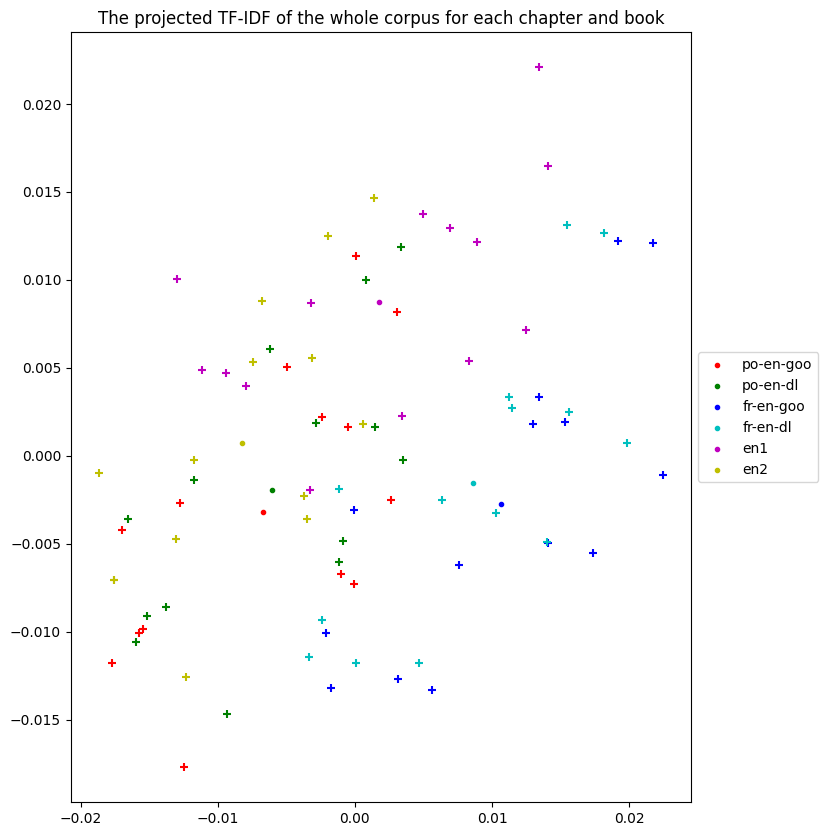

In [41]:
'''Plotting the pca features for each chapter and each book'''
# Applies principal component analysis
pca = PCA(n_components=2)
pca_doc = pca.fit_transform(df4)
pca_chp = pca.transform(df2)

# COLOUR_MAP = "tab10"
# CMAP = plt.get_cmap(COLOUR_MAP)
# rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

# colours = [CMAP(i) for i in rescale(np.arange(6))]
colours = ['r','g','b','c','m','y']
# plt.style.use('ggplot')
ax = plt.subplot(111)
for i in range(6):
    ax.scatter(pca_doc[i,0], pca_doc[i,1], color=colours[i], marker='.', label=BOOKS[i])
    ax.scatter(pca_chp[14*i:14*(i+1),0], pca_chp[14*i:14*(i+1),1], color=colours[i], marker='+')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.set_title('The projected TF-IDF of the whole corpus for each chapter and book')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("all.png")
plt.show()


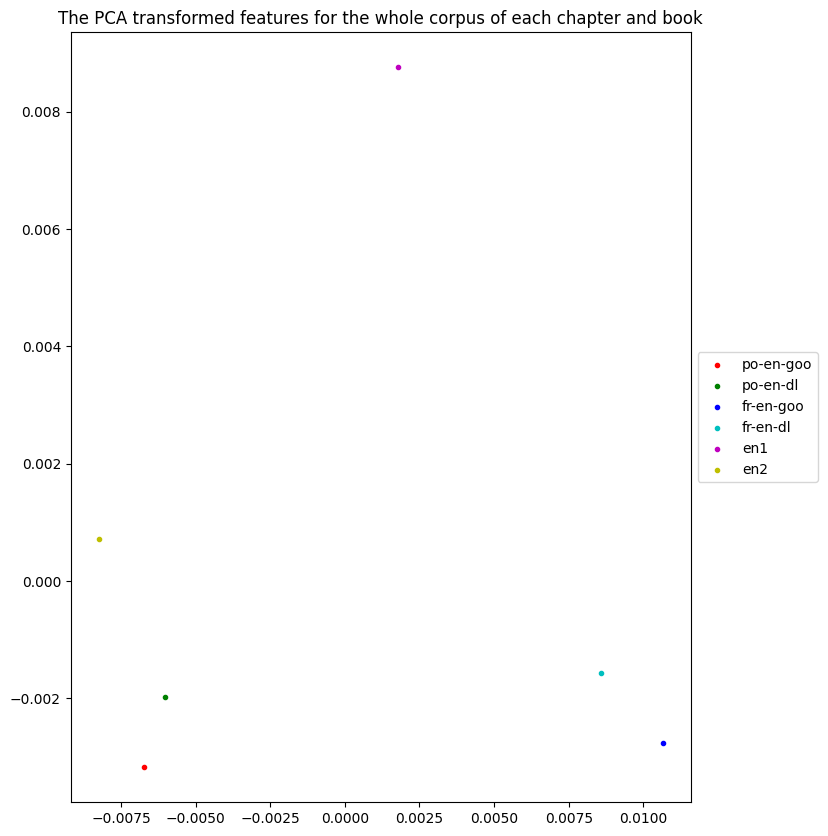

In [42]:
colours = ['r','g','b','c','m','y']
ax = plt.subplot(111)
for i in range(6):
    ax.scatter(pca_doc[i,0], pca_doc[i,1], color=colours[i], marker='.', label=BOOKS[i])

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.set_title('The PCA transformed features for the whole corpus of each chapter and book')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("book.png")
plt.show()

### PCA Comparisom by the pre-defined function words

In [43]:
# Function word corpus is from https://www.edu.uwo.ca/faculty-profiles/docs/other/webb/essential-word-list.pdf
with open('function-words.txt') as f:
    fct_w = f.read().split()
fct_w

['the',
 'which',
 'still',
 'although',
 'forty',
 'and',
 'up',
 'last',
 'past',
 'nobody',
 'of',
 'out',
 'being',
 'himself',
 'unless',
 'to',
 'would',
 'must',
 'seven',
 'mine',
 'a',
 'when',
 'another',
 'eight',
 'anybody',
 'i',
 'your',
 'between',
 'along',
 'till',
 'in',
 'will',
 'might',
 'round',
 'herself',
 'you',
 'their',
 'both',
 'several',
 'twelve',
 'that',
 'who',
 'five',
 'someone',
 'fifteen',
 'it',
 'some',
 'four',
 'whatever',
 'beyond',
 'for',
 'two',
 'around',
 'among',
 'whom',
 'he',
 'because',
 'while',
 'across',
 'below',
 'on',
 'how',
 'each',
 'behind',
 'none',
 'we',
 'other',
 'under',
 'million',
 'nor',
 'they',
 'could',
 'away',
 'outside',
 'more',
 'be',
 'our',
 'every',
 'nine',
 'most',
 'with',
 'into',
 'next',
 'thousand',
 'this',
 'these',
 'anything',
 'shall',
 'have',
 'than',
 'few',
 'myself',
 'but',
 'any',
 'though',
 'themselves',
 'as',
 'where',
 'since',
 'itself',
 'not',
 'over',
 'against',
 'somebody',


In [44]:
# df5 is the tf-idf for function words
df5 = df4[fct_w]

# Applies principal component analysis
pca = PCA(n_components=2)
pca_fnc = pca.fit_transform(df5)
pca_fnc.shape

(6, 2)

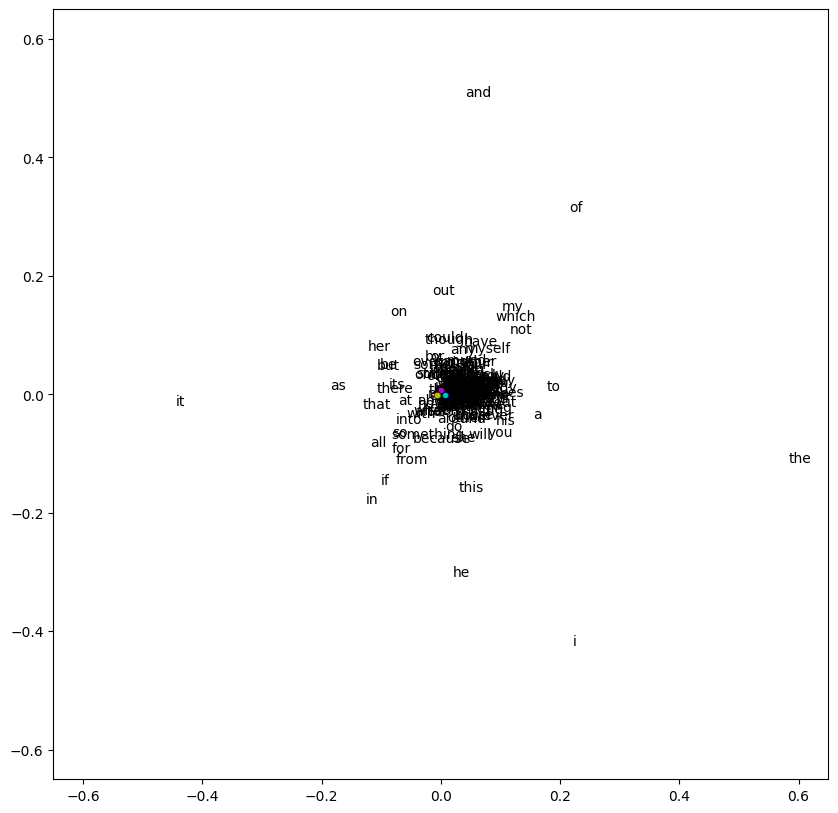

In [45]:
'''Plotting the projected TF-IDF of function words'''
tmp = pca.components_.T
x = tmp-tmp.mean(axis=0)

plt.rcParams["figure.figsize"] = (10,10)
colours = ['r','g','b','c','m','y']

for i in range(176):
    plt.text(x[i,0], x[i,1], fct_w[i], zorder=0)

for i in range(6):
    plt.scatter(pca_fnc[i,0], pca_fnc[i,1], color=colours[i], marker='.', label=BOOKS[i], zorder=20)

plt.xlim([-0.65,0.65])
plt.ylim([-0.65,0.65])
plt.show()

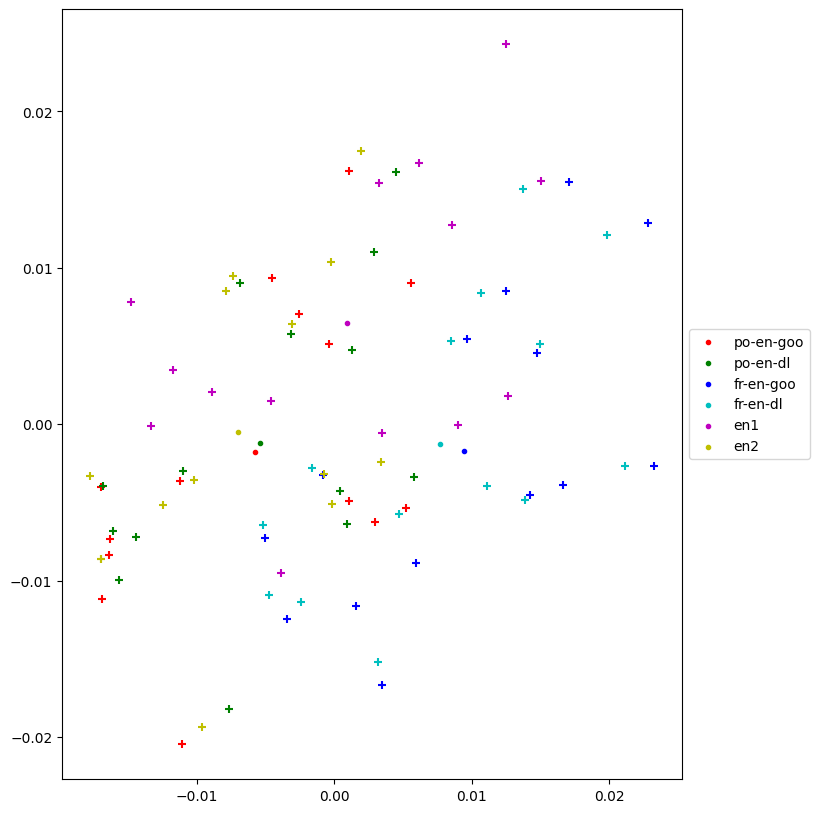

In [46]:
'''Plotting the pca features of function words for each chapter and each book'''

df6 = df2[fct_w]
# Applies principal component analysis
pca = PCA(n_components=2)
pca_fnc_doc = pca.fit_transform(df5)
pca_fnc_chp = pca.transform(df6)

# Plat function words based on chapters and books
colours = ['r','g','b','c','m','y']
ax = plt.subplot(111)
for i in range(6):
    ax.scatter(pca_fnc_doc[i,0], pca_fnc_doc[i,1], color=colours[i], marker='.', label=BOOKS[i])
    ax.scatter(pca_fnc_chp[14*i:14*(i+1),0], pca_fnc_chp[14*i:14*(i+1),1], color=colours[i], marker='+')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

### Main function for pca machine learning

In [66]:
def make_graph(doc1, doc2, words, title, fig_name, kernel="poly"):
    # Construct data
    df_doc = df3.loc[words, [doc1, doc2]].T
    cols = [f"{doc1}-{i}" for i in range(1,15)] + [f"{doc2}-{i}" for i in range(1,15)]
    df_chp = df3.loc[words,cols].T

    # Normalised data
    df_doc = df_doc.div(df_doc.sum(axis=1),axis=0)
    df_chp = df_chp.div(df_chp.sum(axis=1),axis=0)

    # Applies principal component analysis
    pca = PCA(n_components=2)
    doc = pca.fit_transform(df_doc)
    chp = pca.transform(df_chp)

    # Skeloton code for plotting taken from:
    # https://stackoverflow.com/a/51301399
    def make_meshgrid(x, y, h=.02):
        x_min, x_max = x.min() - 1, x.max() + 1
        y_min, y_max = y.min() - 1, y.max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        return xx, yy

    def plot_contours(ax, clf, xx, yy, **params):
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        out = ax.contourf(xx, yy, Z, **params)
        return out

    y = [0]*14 + [1]*14
    LABELS = [doc1, doc2]

    model = svm.SVC(kernel=kernel)
    clf = model.fit(chp, y)

    fig, ax = plt.subplots()
    # Set-up grid for plotting.
    X0, X1 = chp[:, 0], chp[:, 1]
    xx, yy = make_meshgrid(X0, X1)

    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    # ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.scatter(X0[:14], X1[:14], color=plt.cm.coolwarm(0.0), s=20, edgecolors='k', label=LABELS[0])
    ax.scatter(X0[14:], X1[14:], color=plt.cm.coolwarm(1.0), s=20, edgecolors='k', label=LABELS[1])

    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

    ax.set_xlim([-0.05,0.05])
    ax.set_ylim([-0.05,0.05])
    ax.legend()
    plt.savefig(fig_name)
    acurracy = (model.predict(chp) == np.array(y)).sum() / 28
    print(acurracy)
    
    plt.show()


0.8214285714285714


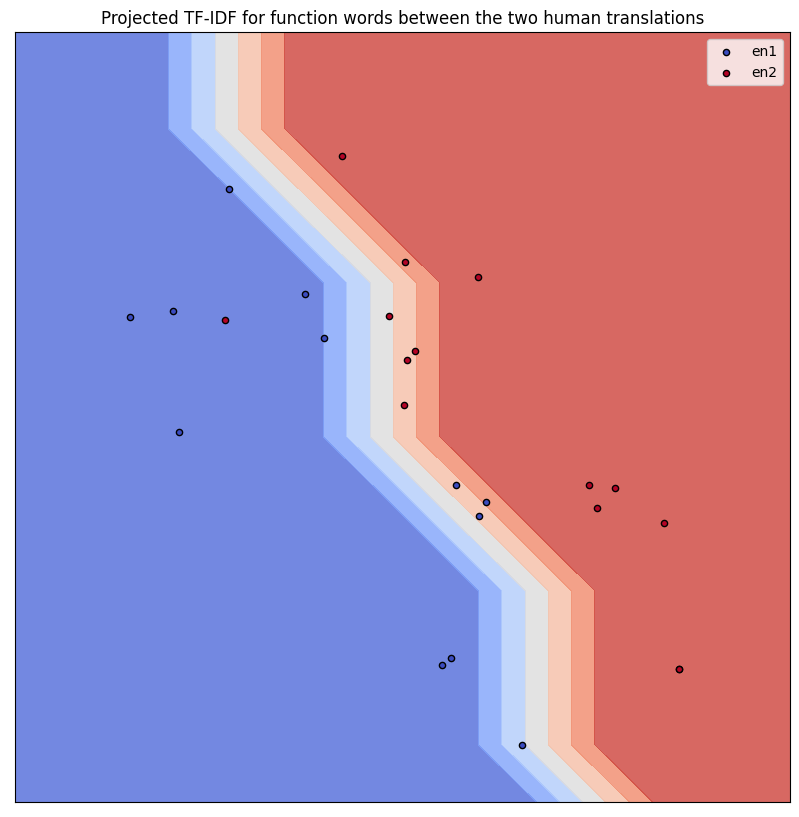

0.8214285714285714


In [67]:
make_graph(
    "en1", "en2", fct_w,
    'Projected TF-IDF for function words between the two human translations',
    'ee-h-fw.png'
)

In [ ]:
'''Analyse the difference between different human translation by function words'''
'''translation from France -> English and Polish -> English'''
'''Question: Can the differences be witnessed?'''
make_graph(
    "en1", "en2", fct_w,
    'Projected TF-IDF for function words between the two human translations',
    'ee-h-fw.png'
)

0.9285714285714286


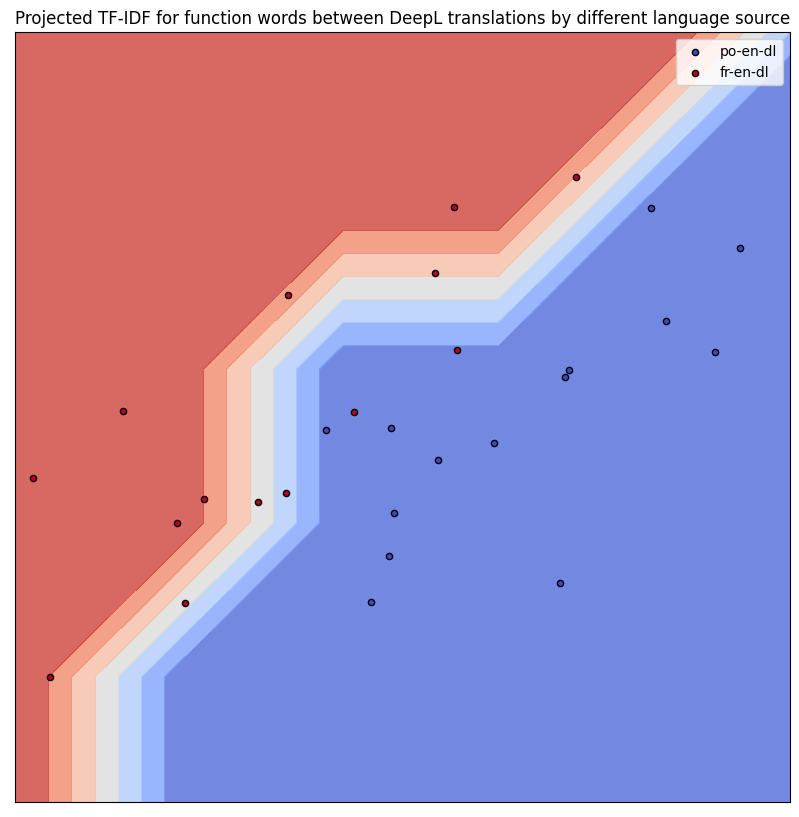

0.9285714285714286


In [68]:
'''Analyse the difference between DeepL translation from different language source by function words '''
'''translation from France -> English and Polish -> English'''
'''Question: Will there be a style for a machine translator (DeepL)?'''

make_graph(
    "po-en-dl", "fr-en-dl", fct_w,
    'Projected TF-IDF for function words between DeepL translations by different language source',
    'fp-dl-fw.png'
)

0.8214285714285714


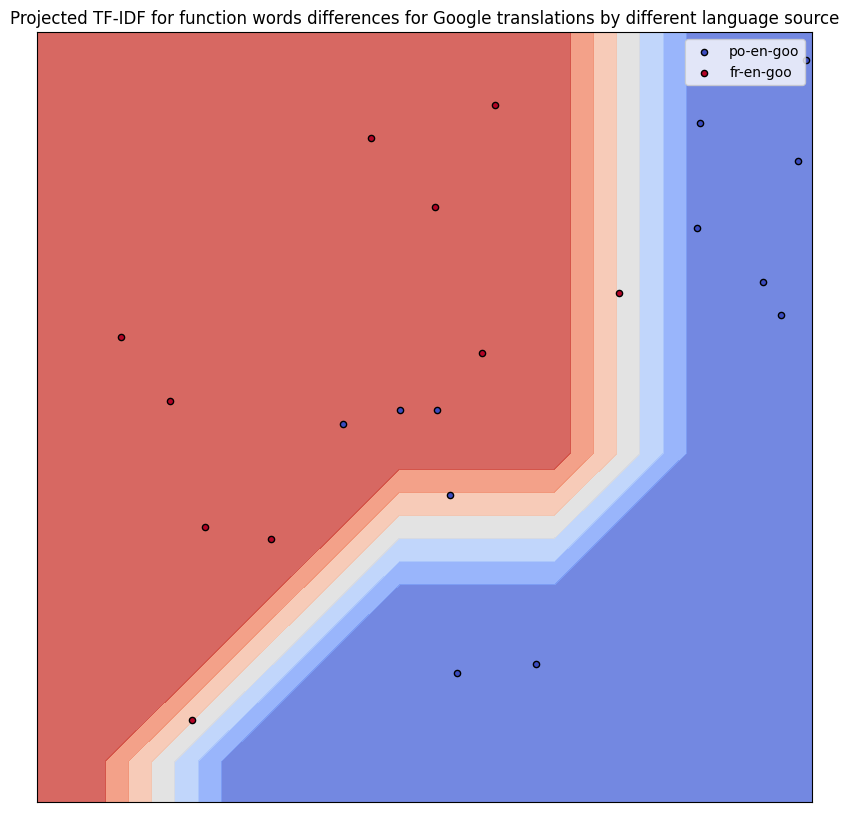

0.8214285714285714


In [69]:
'''Analyse the difference between Goggle translation from different language source by function words '''
'''translation from France -> English and Polish -> English'''
'''Question: Will there be a style for a machine translator (Google)?'''

make_graph(
    "po-en-goo", "fr-en-goo", fct_w,
    'Projected TF-IDF for function words differences for Google translations by different language source',
    'fp-goo-fw.png'
)

0.5357142857142857


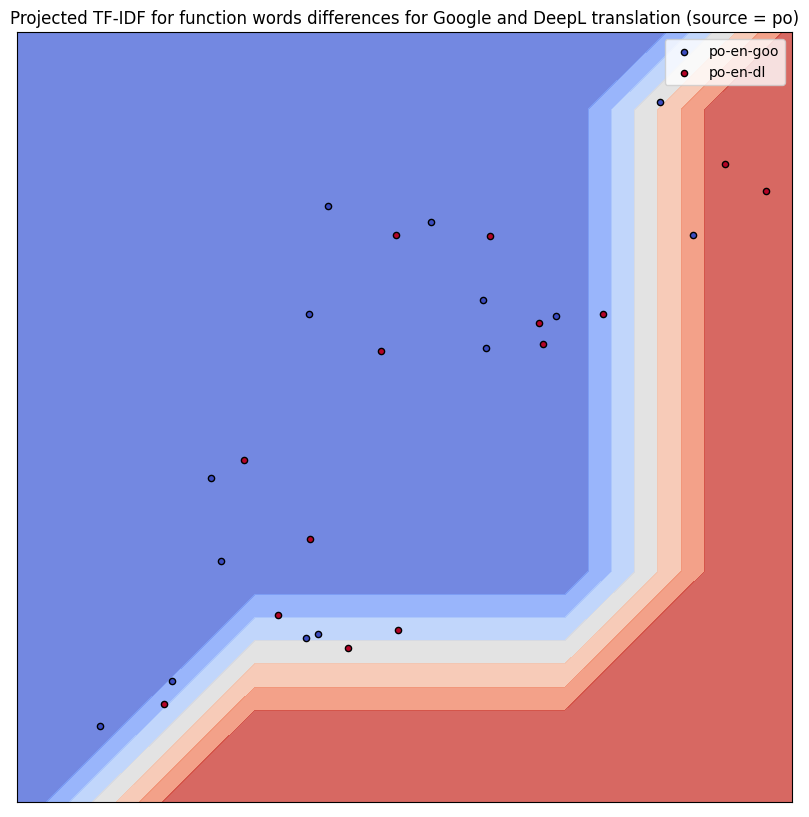

0.5357142857142857


In [70]:
'''Analyse the difference between Google and DeepL by function words '''
'''translation from Polish -> English'''
'''Question: Will the style be explicitly different by different machine translation?'''

make_graph(
    "po-en-goo", "po-en-dl", fct_w,
    'Projected TF-IDF for function words differences for Google and DeepL translation (source = po)',
    'p-goo-dl-fw.png'
)

0.5714285714285714


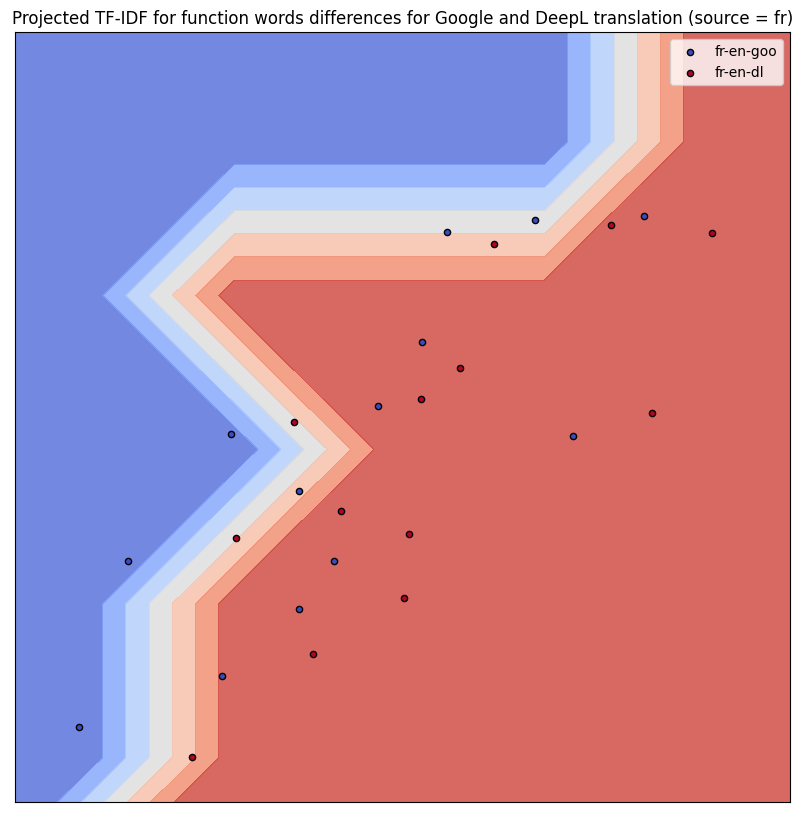

0.5714285714285714


In [71]:
'''Analyse the difference between Google and DeepL by function words '''
'''translation from French -> English'''
'''Question: Will there the style be explicitly different by different machine translation?'''

make_graph(
    "fr-en-goo", "fr-en-dl", fct_w,
    'Projected TF-IDF for function words differences for Google and DeepL translation (source = fr)',
    'fr-goo-dl-fw.png'
)


0.7142857142857143


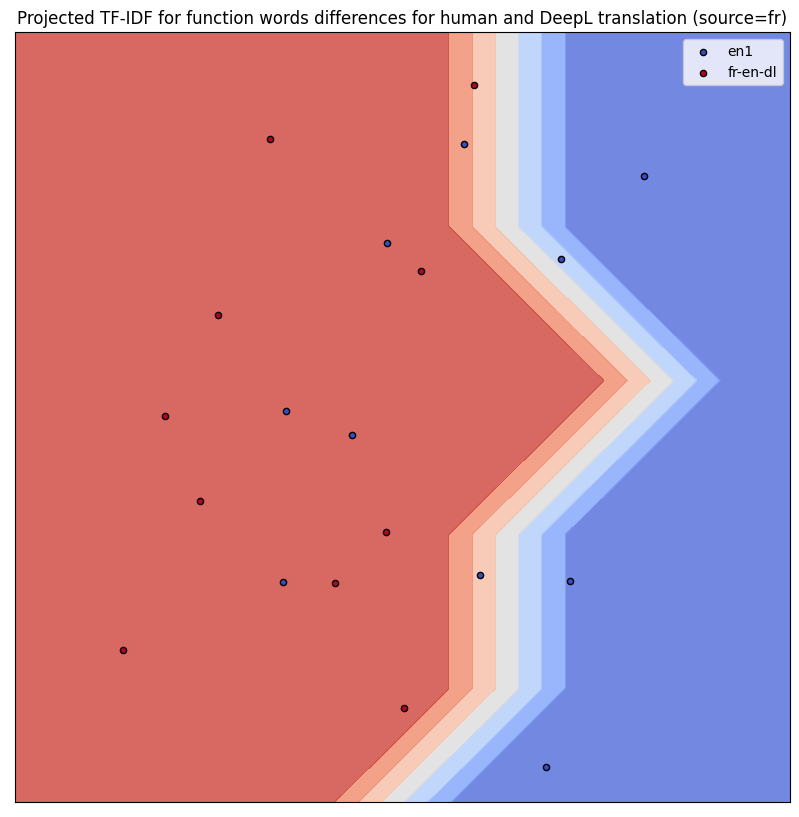

0.7142857142857143


In [72]:
'''Analyse the difference between human and DeepL by function words '''
'''translation from French -> English'''
'''Question: Will there the style be explicitly different between human and machine translation?'''

make_graph(
    "en1", "fr-en-dl", fct_w,
    'Projected TF-IDF for function words differences for human and DeepL translation (source=fr)',
    'fr-h-dl-fw.png'
)

0.6071428571428571


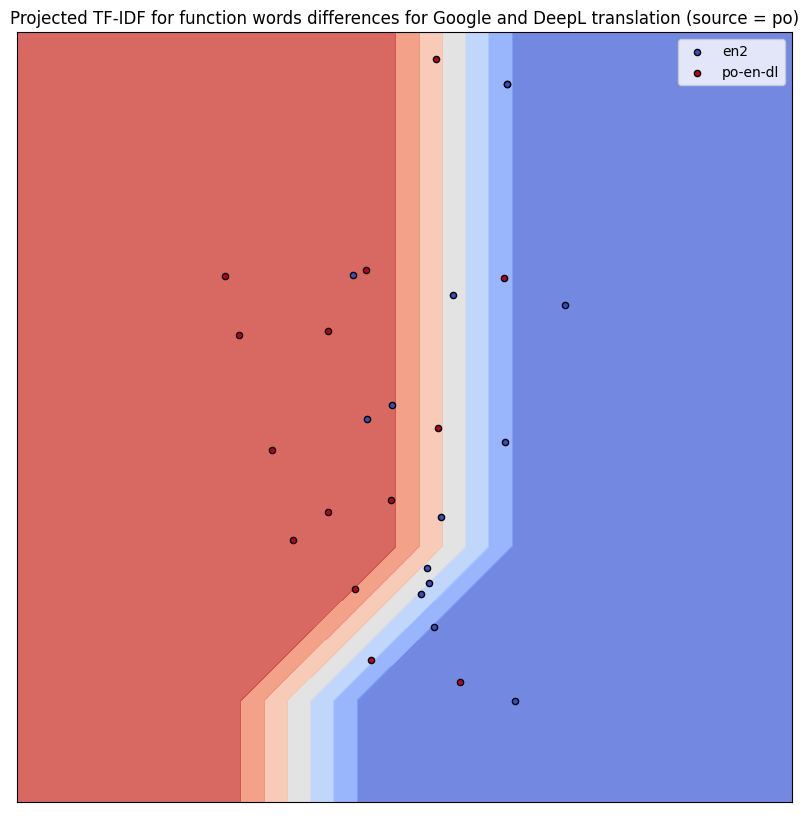

0.6071428571428571


In [73]:
'''Analyse the difference between human and DeepL by function words '''
'''translation from Polish -> English'''
'''Question: Will there the style be explicitly different between human and machine translation?'''
make_graph(
    "en2", "po-en-dl", fct_w,
    'Projected TF-IDF for function words differences for Google and DeepL translation (source = po)',
    'po-goo-dl-fw.png'
)


### Comparison by the PCA of top 200 most frequent words

In [58]:

# Pick out the top 200 most frequent words (exclude any proper nouns) 
BAD_WORDS = ['harey','snaut','sartorius','kelvin','gibarian','kris']
top200 = df.loc[:,~df.columns.isin(BAD_WORDS)].sum(axis=0).sort_values(ascending=[False]).head(200)
top200 = list(top200.index)
# [print(i) for i in top200.index]

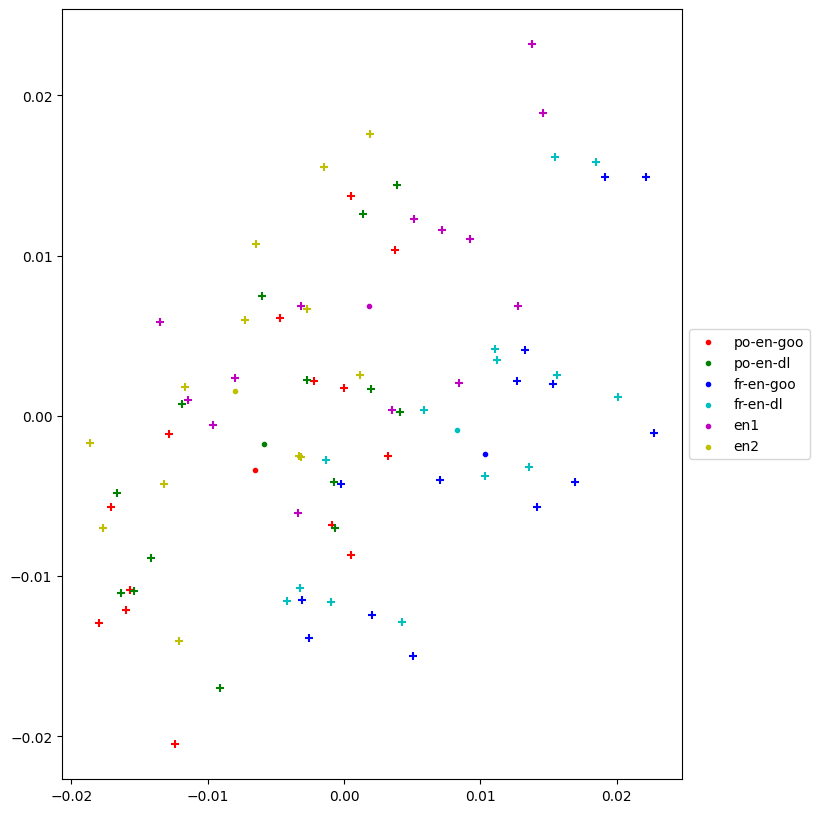

In [59]:
'''Plotting the PCA features of the top 200 for the entire copus by each chapters'''
df6 = df2[top200]
df5 = df4[top200]
# Applies principal component analysis
pca = PCA(n_components=2)
pca_fnc_doc = pca.fit_transform(df5)
pca_fnc_chp = pca.transform(df6)

# Plat function words based on chapters and books
colours = ['r','g','b','c','m','y']
ax = plt.subplot(111)
for i in range(6):
    ax.scatter(pca_fnc_doc[i,0], pca_fnc_doc[i,1], color=colours[i], marker='.', label=BOOKS[i])
    ax.scatter(pca_fnc_chp[14*i:14*(i+1),0], pca_fnc_chp[14*i:14*(i+1),1], color=colours[i], marker='+')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

0.75


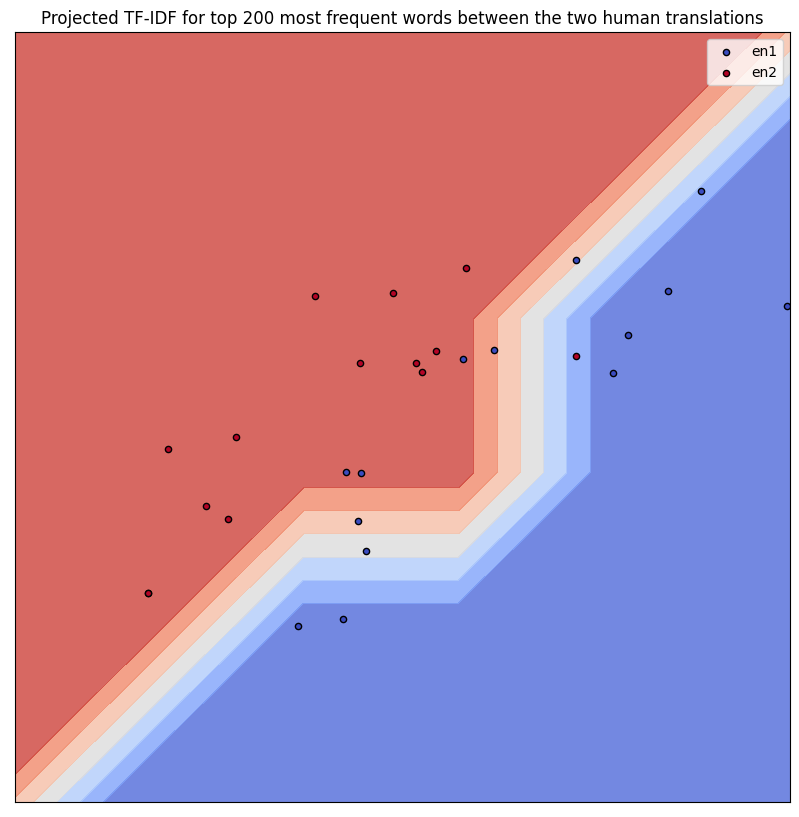

0.75


In [74]:
'''Analyse the difference between the orginal two English translations by function words '''
make_graph(
    "en1", "en2", top200,
    'Projected TF-IDF for top 200 most frequent words between the two human translations',
    'ee-h-200.png'
)

0.7857142857142857


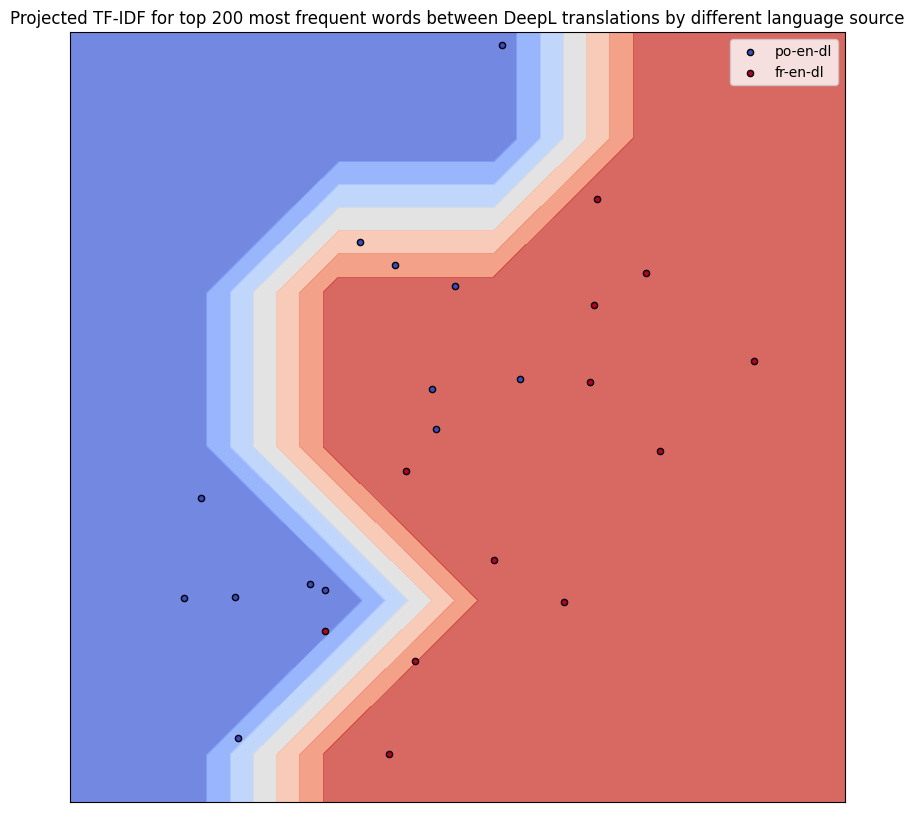

0.7857142857142857


In [75]:
'''Analyse the difference between DeepL translation from different language source by top 200 most frequent words '''

make_graph(
    "po-en-dl", "fr-en-dl", top200,
    'Projected TF-IDF for top 200 most frequent words between DeepL translations by different language source',
    'fp-dl-200.png'
)

0.8928571428571429


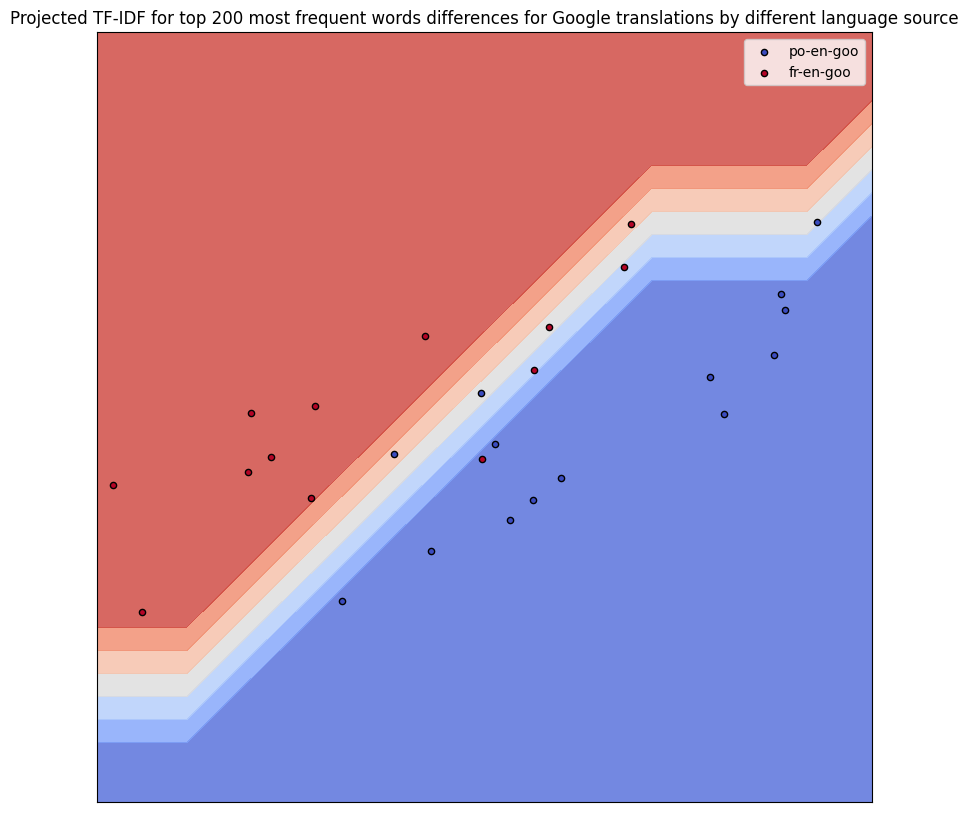

0.8928571428571429


In [76]:
'''Analyse the difference between Goggle translation from different language source by top 200 most frequent words '''
'''translation from France -> English and Polish -> English'''
'''Question: Will there be a style for a machine translator (Google)?'''

make_graph(
    "po-en-goo", "fr-en-goo", top200,
    'Projected TF-IDF for top 200 most frequent words differences for Google translations by different language source',
    'fp-goo-200.png'
)

0.5


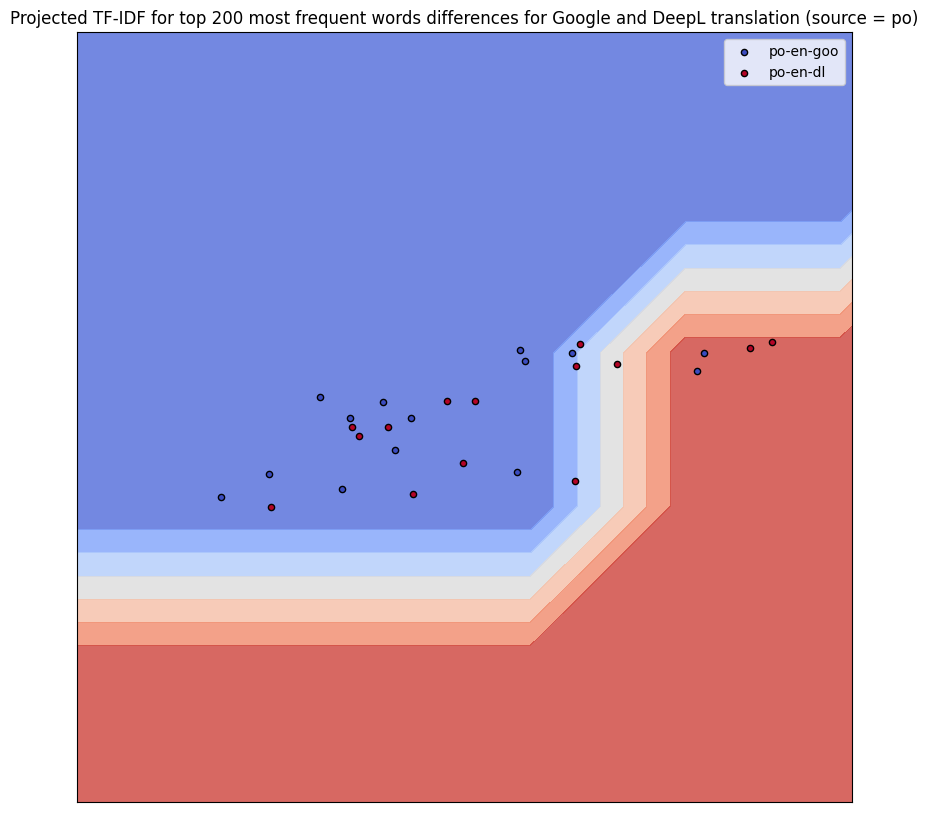

0.5


In [77]:
'''Analyse the difference between Google and DeepL by top 200 most frequent words '''
'''translation from Polish -> English'''
'''Question: Will the style be explicitly different by different machine translation?'''

make_graph(
    "po-en-goo", "po-en-dl", top200,
    'Projected TF-IDF for top 200 most frequent words differences for Google and DeepL translation (source = po)',
    'p-goo-dl-200.png'
)

0.6071428571428571


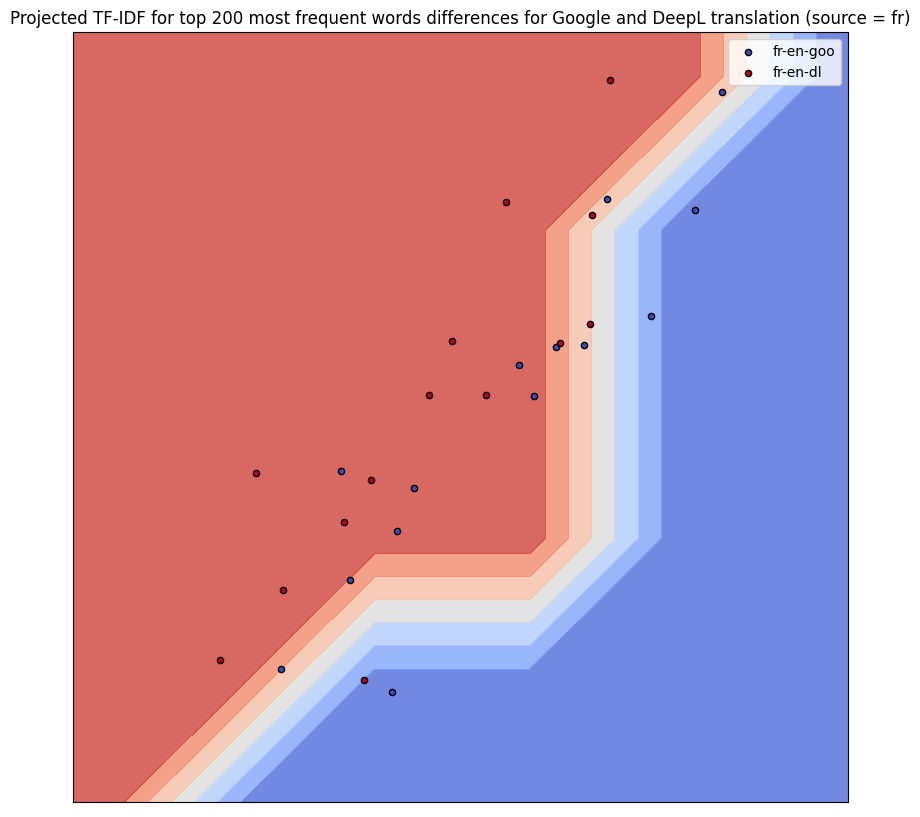

0.6071428571428571


In [78]:
'''Analyse the difference between Google and DeepL by top 200 most frequent words'''
'''translation from French -> English'''
'''Question: Will there the style be explicitly different by different machine translation?'''

make_graph(
    "fr-en-goo", "fr-en-dl", top200,
    'Projected TF-IDF for top 200 most frequent words differences for Google and DeepL translation (source = fr)',
    'fr-goo-dl-200.png'
)

0.7857142857142857


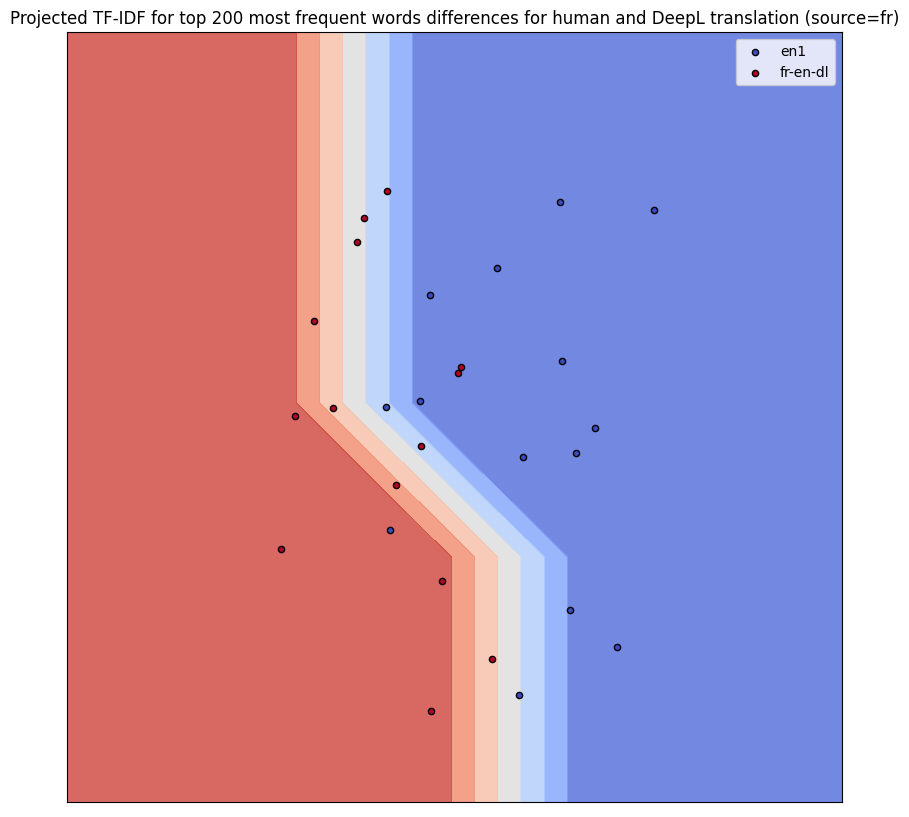

0.7857142857142857


In [79]:
'''Analyse the difference between human and DeepL by top 200 most frequent words '''
'''translation from French -> English'''
'''Question: Will there the style be explicitly different between human and machine translation?'''

make_graph(
    "en1", "fr-en-dl", top200,
    'Projected TF-IDF for top 200 most frequent words differences for human and DeepL translation (source=fr)',
    'fr-h-dl-200.png'
)

0.7857142857142857


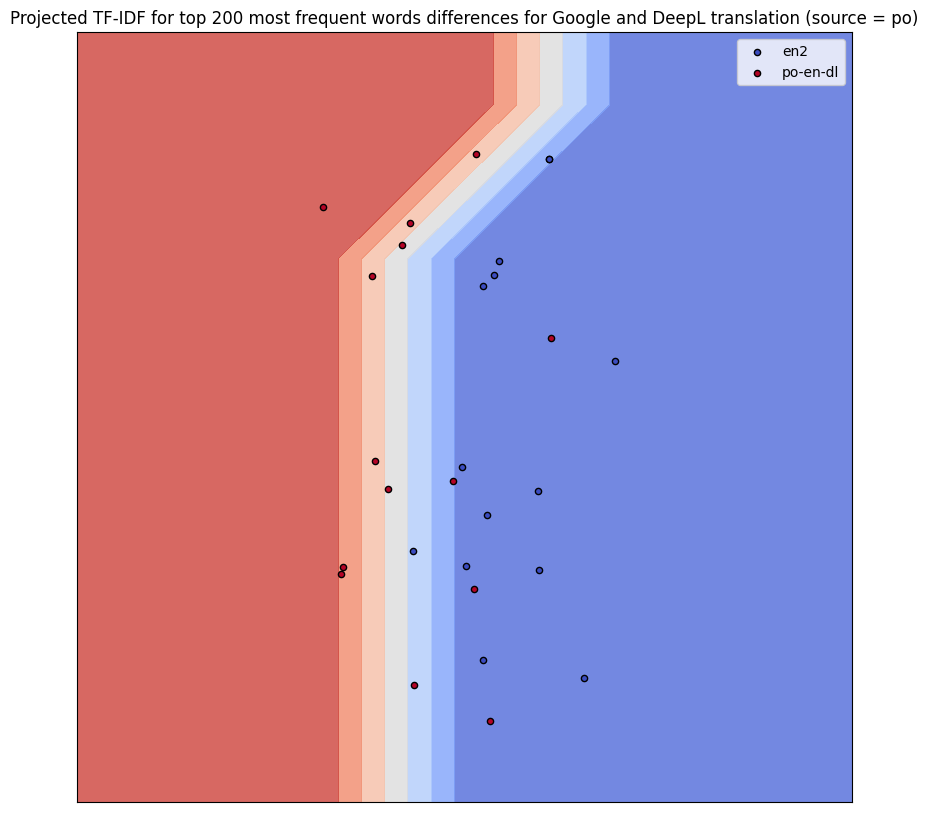

0.7857142857142857


In [80]:
'''Analyse the difference between human and DeepL by top 200 most frequent words '''
'''translation from Polish -> English'''
'''Question: Will there the style be explicitly different between human and machine translation?'''

make_graph(
    "en2", "po-en-dl", top200,
    'Projected TF-IDF for top 200 most frequent words differences for Google and DeepL translation (source = po)',
    'po-goo-dl-200.png'
)
